An automatic way of calculating littoral fraction from a shapefile of water bodies and a list of points



In [3]:
 '''DEPRECATED. SEE .PY VERSION INSTEAD. Script to calculate total vegetated area for each water body, given pt
 inputs of water bodies
Run (#2) after raster2percentagepoly.py < PYTHON not IPYNB 
Inputs:           (from input dir containing list of classified rasters)
                  water_classes =         class numbers for water or
                                          inundated vegetation 
                  xls_in =                spreadsheet w lake locs
                  shp_in                  shapefile with lake polygons containing em % from raster2percentagepoly.ipynb 
                  Buffer distance


Outputs: tall csv of lakes and EM fractions
 Ethan Kyzivat, April 2020, updated April 2021


TODO: Add buffers before spatial join, fix matching crs problem... X'''

'Script to calculate total vegetated area for each water body, given pt\ninputs of water bodies\nRun (#2) after raster2percentagepoly.py < PYTHON not IPYNB \nInputs:           (from input dir containing list of classified rasters)\n                 water_classes =         class numbers for water or\n                                         inundated vegetation \n                 xls_in =                spreadsheet w lake locs\n                 shp_in                  shapefile with lake polygons containing em % from raster2percentagepoly.ipynb \n                 Buffer distance\n\n\nOutputs: tall csv of lakes and EM fractions\nEthan Kyzivat, April 2020, updated April 2021\n\n\nTODO: Add buffers before spatial join, fix matching crs problem... X'

In [4]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from pandas import DataFrame
from shapely.geometry import Point

%autosave 60

Autosaving every 60 seconds


In [5]:
# I/O to pandas dataframe and convert to numeric
xls_in='/mnt/f/PAD2019/Chemistry/ABoVE_Lakes_all.csv'
shp_in='/mnt/f/PAD2019/classification_training/PixelClassifier/Test35/shp/padelE_36000_19059_003_190904_L090_CX_01_LUT-Freeman_cls_poly.shp'
csv_out_pth='/mnt/f/PAD2019/Chemistry/practice/ABoVE_Lakes_all_em_fraction_v2.csv' # update output name

df=pd.read_csv(xls_in, encoding='ISO-8859-1')
df.Latitude_dd.dtype
df.dtypes
# df.astype({'Latitude_dd': 'float64'}).dtypes
df['Latitude_dd']=df['Latitude_dd'].astype('float64')
# df.head()
# df.Latitude_dd + df.Longitude_dd
df.dtypes
# df['Longitude_dd']

site             object
date             object
Latitude_dd     float64
Longitude_dd    float64
dtype: object

(58, 59.5)

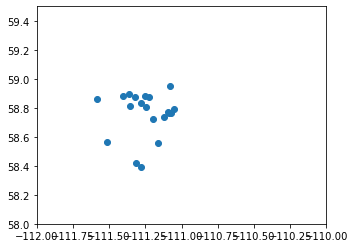

In [9]:
# convert to geopandas dataframe
geometry = [Point(xy) for xy in zip(df.Longitude_dd, df.Latitude_dd)] # https://gist.github.com/nygeog/2731427a74ed66ca0e420eaa7bcd0d2b
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/ # EK: need to define crs
points = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
points.plot()
plt.xlim(-112, -110)
plt.ylim(58, 59.5) # center on PAD

In [10]:
## load in polygons
poly=gpd.read_file(shp_in)
poly=gpd.read_file(shp_in) # repeating seems to allow it to load crs...weird!
poly

,label,em_fractio,area_px_m2,perimeter_,geometry
0,3,1.000000,39.400554,0.000000,"POLYGON ((-877502.521230536 2200084.8563, -877..."
1,4,1.000000,157.602217,20.130965,"POLYGON ((-876736.7661484339 2200084.8563, -87..."
2,5,0.333333,118.201662,6.276986,"POLYGON ((-876699.1060624288 2200084.8563, -87..."
3,6,1.000000,157.602217,20.130965,"POLYGON ((-876667.7226574246 2200084.8563, -87..."
4,7,1.000000,354.604987,47.838922,"POLYGON ((-875274.2994752387 2200084.8563, -87..."
...,...,...,...,...,...
42138,42139,1.000000,78.801108,0.000000,POLYGON ((-874816.1017621775 2135441.311991155...
42139,42140,1.000000,78.801108,0.000000,POLYGON ((-874050.3466800754 2135441.311991155...
42140,42141,1.000000,78.801108,0.000000,POLYGON ((-873818.1094830444 2135441.311991155...
42141,42142,1.000000,39.400554,0.000000,POLYGON ((-871627.5478137521 2135441.311991155...


In [5]:
# poly.crs='+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
poly.crs

{'proj': 'aea',
 'lat_1': 50,
 'lat_2': 70,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

# Buffer before spatial join

In [8]:
## reproject points
# points1=points.to_crs(crs='PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')
# points1=points.to_crs(epsg=102001)
# points1=points.to_crs({'init': 'epsg:102001'}) # test # HERE <-----------------------------
# points1=points.to_crs(crs='+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')
points=points.to_crs(poly.crs) # use CRS of polygons
points.crs
# dir(poly)
# type(poly)
# poly.crs={'init': 'epsg:102001'}
# poly.crs
points.crs

{'proj': 'aea',
 'lat_1': 50,
 'lat_2': 70,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

,site,date,Latitude_dd,Longitude_dd,geometry
0,Chillowese,7/11/2019,58.8143,-111.3590,"POLYGON ((-867362.0354573639 2184788.2439718, ..."
1,Limon,7/12/2019,58.4211,-111.3157,POLYGON ((-874998.9943648572 2140960.952482483...
2,Roche Pond,7/15/2019,58.8330,-111.2830,POLYGON ((-862667.9825365068 2185867.742810063...
3,Dore Lake,7/16/2019,58.7904,-111.0500,POLYGON ((-850807.6815685376 2178204.976050631...
4,Little Lake,7/16/2019,58.7364,-111.1220,POLYGON ((-856171.0837860435 2173171.954050455...


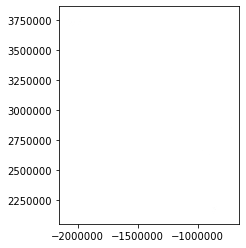

In [9]:
# points['buffer_geom']=points.buffer(30) # 30 m
# To change which column is the active geometry column, use the GeoDataFrame.set_geometry() method. # https://geopandas.org/data_structures.html
buffer=15
points_buffer=points # init
points_buffer['geometry']=points.buffer(buffer, 2) # 15 m, scale of 1 creates a 6-pt circle, scale 2: 9 pts
points_buffer.plot() # why is it empty??? Becasue polygons are so small at that scale!
# points_buffer[8]
type(points_buffer)
# type(points1)
points_buffer.set_geometry('geometry')
points_buffer.head()
# points.head()
# points.iloc[1,:]
# print(points_buffer.geom[1])
# points_buffer.geometry

# Spatial join

In [10]:
# points_buffer.plot()
# points_buffer['geometry'][6]
points_buffer.geometry[0:2]
points_buffer.iloc[0,4]
print(points_buffer.geometry[1])

POLYGON ((-874998.9943648572 2140960.952482483, -875003.3877631394 2140950.345880765, -875013.9943648572 2140945.952482483, -875024.600966575 2140950.345880765, -875028.9943648572 2140960.952482483, -875024.600966575 2140971.559084201, -875013.9943648572 2140975.952482483, -875003.3877631394 2140971.559084201, -874998.9943648572 2140960.952482483))


In [11]:
## spatial join!

points_join=gpd.sjoin(points_buffer, poly, how="left", op='intersects')
points_join.head()

,site,date,Latitude_dd,Longitude_dd,geometry,index_right,label,em_fractio,area_px_m2,perimeter_
0,Chillowese,7/11/2019,58.8143,-111.3590,"POLYGON ((-867362.0354573639 2184788.2439718, ...",9121.0,7898.0,0.719646,5.260368e+05,9105.499256
1,Limon,7/12/2019,58.4211,-111.3157,POLYGON ((-874998.9943648572 2140960.952482483...,36721.0,34680.0,0.393372,8.276717e+06,135617.967200
2,Roche Pond,7/15/2019,58.8330,-111.2830,POLYGON ((-862667.9825365068 2185867.742810063...,8203.0,8094.0,0.591640,7.352143e+04,1725.362091
3,Dore Lake,7/16/2019,58.7904,-111.0500,POLYGON ((-850807.6815685376 2178204.976050631...,NaN,NaN,NaN,NaN,NaN
4,Little Lake,7/16/2019,58.7364,-111.1220,POLYGON ((-856171.0837860435 2173171.954050455...,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f'Number of joined polygons: {(~np.isnan(points_join.label)).sum()} (buffer ={buffer})')

Number of joined polygons: 13 (buffer =15)


# print out csv

In [27]:
# add attiribute for filename
scene_name=os.path.basename(shp_in)[:40] #.split('_')
scene_id=scene_name.split('_')[1]
date=scene_name.split('_')[4]
print(f'Added attributes:\n\t{scene_name}\n\t{scene_id}\n\t{date}')
# print(scene_id)
# print(date)
points_join['scene_id']=scene_id
points_join['scene_name']=scene_name
points_join['date']=date
points_join.head()

Added attributes:
	padelE_36000_19059_003_190904_L090_CX_01
	36000
	190904


,site,date,Latitude_dd,Longitude_dd,geometry,index_right,label,em_fractio,area_px_m2,perimeter_,scene,scene_id,scene_name
0,Chillowese,190904,58.8143,-111.3590,"POLYGON ((-867362.0354573639 2184788.2439718, ...",9121.0,7898.0,0.719646,5.260368e+05,9105.499256,padelE_36000_19059_003_190904_L090_CX_01,36000,padelE_36000_19059_003_190904_L090_CX_01
1,Limon,190904,58.4211,-111.3157,POLYGON ((-874998.9943648572 2140960.952482483...,36721.0,34680.0,0.393372,8.276717e+06,135617.967200,padelE_36000_19059_003_190904_L090_CX_01,36000,padelE_36000_19059_003_190904_L090_CX_01
2,Roche Pond,190904,58.8330,-111.2830,POLYGON ((-862667.9825365068 2185867.742810063...,8203.0,8094.0,0.591640,7.352143e+04,1725.362091,padelE_36000_19059_003_190904_L090_CX_01,36000,padelE_36000_19059_003_190904_L090_CX_01
3,Dore Lake,190904,58.7904,-111.0500,POLYGON ((-850807.6815685376 2178204.976050631...,NaN,NaN,NaN,NaN,NaN,padelE_36000_19059_003_190904_L090_CX_01,36000,padelE_36000_19059_003_190904_L090_CX_01
4,Little Lake,190904,58.7364,-111.1220,POLYGON ((-856171.0837860435 2173171.954050455...,NaN,NaN,NaN,NaN,NaN,padelE_36000_19059_003_190904_L090_CX_01,36000,padelE_36000_19059_003_190904_L090_CX_01


In [13]:
csv_out=pd.DataFrame(points_join.copy())
del csv_out['geometry']
csv_out.head()
# points_join.head()
csv_out.to_csv(csv_out_pth)

# Scrap

In [5]:
# another way that doesn't work bc only a dataframe...
gdf = gpd.read_file(xls_in)
gdf.head()

,site,date,Latitude_dd,Longitude_dd,geometry
0,Chillowese,7/11/2019,58.8143,-111.359,None
1,Limon,7/12/2019,58.4211,-111.3157,None
2,Roche Pond,7/15/2019,58.833,-111.283,None
3,Dore Lake,7/16/2019,58.7904,-111.05,None
4,Little Lake,7/16/2019,58.7364,-111.122,None


In [15]:
# concat test
csv2=csv_out.copy()
csv_cat=pd.concat((csv_out, csv2))
csv_cat
# csv2

,site,date,Latitude_dd,Longitude_dd,index_right,label,em_fractio,area_px_m2,perimeter_
0,Chillowese,7/11/2019,58.8143,-111.3590,9121.0,7898.0,0.719646,5.260368e+05,9105.499256
1,Limon,7/12/2019,58.4211,-111.3157,36721.0,34680.0,0.393372,8.276717e+06,135617.967200
2,Roche Pond,7/15/2019,58.8330,-111.2830,8203.0,8094.0,0.591640,7.352143e+04,1725.362091
3,Dore Lake,7/16/2019,58.7904,-111.0500,NaN,NaN,NaN,NaN,NaN
4,Little Lake,7/16/2019,58.7364,-111.1220,NaN,NaN,NaN,NaN,NaN
5,Robert's Cabin Pond,7/16/2019,58.8057,-111.2430,10104.0,9907.0,0.113617,1.380201e+05,1800.055055
6,Flett Lake,7/17/2019,58.9539,-111.0783,NaN,NaN,NaN,NaN,NaN
7,PAD3,7/18/2019,58.5616,-111.5110,23254.0,22595.0,0.386554,4.190249e+05,12623.001558
8,Egg Lake,7/19/2019,58.8835,-111.4004,4588.0,3987.0,0.746098,2.271836e+05,10736.776527
9,Green Star Lake,7/19/2019,58.8967,-111.3616,4190.0,3860.0,0.053554,2.045283e+05,4373.963765


In [7]:
# try without copying
# points['geom_buffer']=points.buffer(30, 2)
# points.set_geometry('geom_buffer')

In [11]:
!file /mnt/f/PAD2019/Chemistry/ABoVE_Lakes_all.csv

/mnt/f/PAD2019/Chemistry/ABoVE_Lakes_all.csv: ISO-8859 text, with CRLF line terminators
